In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
import random

EPOCAS = 10

def sigmoid(x):
    """
        Funcion logistica (Sigmoid).
    """
    return 1.0/(1.0+np.exp(-x))

def sigmoid_prime(x):
    """
        Funcion logistica (Sigmoid).
    """
    return sigmoid(x)*(1-sigmoid(x))

class Perceptron:

    def __init__(self, n_entradas, eta=0.1, bias=None, alpha=0.1):
        self.pesos_sinapticos = np.random.uniform(
            low=-0.05, high=0.05, size=(n_entradas,))
        self.n_entradas = n_entradas
        self.bias = bias if bias else random.random()
        # Tasa de aprendizaje
        self.eta = eta
        # Constante de momentum
        self.alpha = alpha
        self.delta_anterior = 0
        self.gradiente_local = 0

    def calcular(self, estimulo):
        # Realizar operaciones vectoriales de numpy
        y = np.dot(self.pesos_sinapticos, estimulo)
        y += self.bias
        self.v = y
        self.y = sigmoid(y)
        return self.y

    def entrenar(self, estimulo):
        # eta siendo la tasa de aprendizaje
        self.calcular(estimulo)
        
#         print(type(estimulo), estimulo)
        delta = self.alpha * self.delta_anterior \
            * self.eta * self.gradiente_local * estimulo

        # Guardamos el nuevo delta
        self.delta_anterior = delta

        self.pesos_sinapticos += delta
        return self.pesos_sinapticos

class RedNeuronal:

    def __init__(self, n_entrada, n_oculta, n_salida, eta=0.1, alpha=0.1):

        self.n_entrada = n_entrada
        self.n_oculta = n_oculta
        self.n_salida = n_salida

        self.capa_oculta = []
        self.capa_salida = []
        self.bias = []
        self.ys = []

        self.eta = eta
        self.alpha = alpha

        self.err = []

        # Inicializar las capas
        for _ in range(self.n_oculta):
            p = Perceptron(self.n_entrada, eta=eta, alpha=alpha)
            self.capa_oculta.append(p)

        for _ in range(self.n_salida):
            p = Perceptron(self.n_oculta, eta=eta, alpha=alpha)
            self.capa_salida.append(p)
        

    def evaluar(self, entrada):

        x = entrada
        y_oculta = []
        y_salida = []

        for perceptron in self.capa_oculta:
            y = perceptron.calcular(x)
            y_oculta.append(y)

        for perceptron in self.capa_salida:
            y = perceptron.calcular(y_oculta)
            y_salida.append(y)
            
        return y_salida


    def entrenar(self, datos, resultados):
        error_avg = 0
        N = 0
        for estimulo, resultado in zip(datos, resultados):
        #Feedforward
            
            # Evaluamos el estimulo
            self.evaluar(estimulo)

            # Contruimos el arreglo de resultados
            # esperados segun la respuesta correcta
            esperados = np.array([0.1 for i in range(self.n_salida)])
            esperados[int(resultado)] = 0.9


        # BackPropagation
            
            # Capa de salida
            for neurona, d  in zip(self.capa_salida, esperados):
                error = d - neurona.y
                error_avg += (error ** 2)
                
                # Calculo del gradiente local de la capa de salida
                neurona.gradiente_local = error * sigmoid_prime(neurona.v)
                
                # Actualizacion de pesos de la nuerona
                for i in range(len(neurona.pesos_sinapticos)):
                    
                    delta = self.eta * neurona.gradiente_local * self.capa_oculta[i].y
                    momentum = self.alpha * neurona.delta_anterior
                    
                    # Calculo de delta con momentum
                    nuevo_delta = momentum + delta
                    # Actualizacion del peso
                    neurona.pesos_sinapticos[i] += nuevo_delta
                    #Guardar la variacion del peso
                    neurona.delta_anterior = nuevo_delta
                    
            # Capa ocutla
            for j, neurona in enumerate(self.capa_oculta):
                # Calculamos sigma = Sum de gradientes locales * peso_sinaptico
                # correspodiente de cada neurona
                sigma = 0
                for k in self.capa_salida:
                    sigma += k.gradiente_local * k.pesos_sinapticos[j]
                neurona.gradiente_local = sigmoid_prime(neurona.v) * sigma

                for i in range(len(neurona.pesos_sinapticos)):
                    delta = self.eta * neurona.gradiente_local * estimulo[i]
                    momentum = self.alpha * neurona.delta_anterior
                    
                    # Calculo de delta con momentum
                    nuevo_delta = momentum + delta
                    # Actualizacion del peso
                    neurona.pesos_sinapticos[i] += nuevo_delta
                    #Guardar variacion del peso
                    neurona.delta_anterior = nuevo_delta


            N += 1

        error_avg = error_avg /(2 * N)
        print("Error medio", error_avg)
        return error_avg

In [2]:
# Cargar los datos de entrenamiento
train = []
expected_train = []
test = []
expected_test = []
with open('/content/drive/My Drive/Colab Notebooks/mnist_train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    
    for row in csv_reader:
        train.append(np.array(row[1:]) / 255)
        expected_train.append(row[0])
        
        
with open('/content/drive/My Drive/Colab Notebooks/mnist_test.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    
    for row in csv_reader:
        test.append(np.array(row[1:]) / 255)
        expected_test.append(row[0])
        

In [3]:
error_medio = []

def entrenar(red, epocas=1):
    """
    Entrenar la red
    """
    error_medio = []
    start = time.time()
    print("Empezando el entrenamiento...")
    for epoca in range(epocas):
        print(f"Epoca {epoca}")
        err = red.entrenar(train, expected_train)
        error_medio.append(err)
        print(f"Tiempo: {time.time() - start}seg\n")

def verificar(red):
    
    print("Verificando entrenamiento...")
    count = 0
    buenos = 0
    malos = 0
    for t, r in zip(test, expected_test):
        y_salida = red.evaluar(t)
        # print("Salida: ", y_salida[int(r)], r)
        prueba = False
        if y_salida[int(r)] >= 0.9:
            prueba = True
        for i, y in enumerate(y_salida):
            if i != r and y >= 0.9:
                prueba = False
        
        if prueba:
            buenos +=1
        else:
            malos+=1
        count +=1
    
    print(f"Datos Leidos: {count}")
    print(f"Datos buenos {buenos}, {buenos/count}")
    print(f"Datos malos {malos}, {malos/count}")

Experimento 1:

In [12]:
r = RedNeuronal(784,20,10,alpha=0.9)
entrenar(r, 10)
verificar(r)

Empezando el entrenamiento...
Epoca 0
Training 0
Training 10000
Training 20000
Training 30000
Training 40000
Training 50000
Error medio 0.0816325839229968
Tiempo: 870.936891078949seg

Epoca 1
Training 0
Training 10000
Training 20000
Training 30000
Training 40000
Training 50000
Error medio 0.04651530987219689
Tiempo: 1776.10231924057seg

Epoca 2
Training 0
Training 10000
Training 20000
Training 30000
Training 40000
Training 50000
Error medio 0.04124855315798053
Tiempo: 2648.7999403476715seg

Epoca 3
Training 0
Training 10000
Training 20000
Training 30000
Training 40000
Training 50000
Error medio 0.038589210454528976
Tiempo: 3524.8337388038635seg

Epoca 4
Training 0
Training 10000
Training 20000
Training 30000
Training 40000
Training 50000
Error medio 0.03691414019438592
Tiempo: 4402.567929267883seg

Epoca 5
Training 0
Training 10000
Training 20000
Training 30000
Training 40000
Training 50000
Error medio 0.03576393760906795
Tiempo: 5282.9043254852295seg

Epoca 6
Training 0
Training 10000

Para no volver a hacer el entrenamiento, copiamos los errores medios de cada epoca para graficarlo

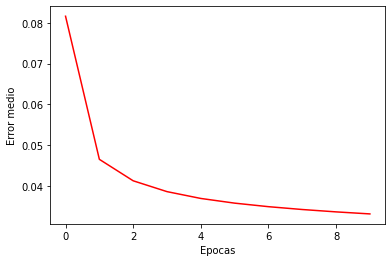

In [5]:
errores = [0.0816325839229968, 0.04651530987219689, 0.04124855315798053, 0.038589210454528976, 0.03691414019438592, 0.03576393760906795,
           0.03489585394120159, 0.0342002255084833, 0.03361850771045981, 0.0331191967821686]
plt.plot([i for i in range(EPOCAS)], errores, 'r-')
plt.xlabel("Epocas")
plt.ylabel("Error medio")
plt.show()

In [ ]:
r1 = RedNeuronal(784,50,10,alpha=0.9)
entrenar(r1, EPOCAS)
verificar(r1)

plt.plot([i for i in range(EPOCAS)], error_medio, 'r-')
plt.xlabel("Epocas")
plt.ylabel("Error medio")
plt.show()

Empezando el entrenamiento...
Epoca 0
Error medio 0.17526214699253187
Tiempo: 2746.2414214611053seg

Epoca 1
Error medio 0.12008253839509551
Tiempo: 5492.446468830109seg

Epoca 2
Error medio 0.11086991384286933
Tiempo: 8221.06752371788seg

Epoca 3


In [ ]:
r2 = RedNeuronal(784,100,10,alpha=0.9)
entrenar(r2, EPOCAS)
verificar(r2)

plt.plot([i for i in range(EPOCAS)], error_medio, 'r-')
plt.xlabel("Epocas")
plt.ylabel("Error medio")
plt.show()

Experimento 2: 

In [ ]:
r3 = RedNeuronal(784,100,10,eta=0.1, alpha=0)
entrenar(r3, EPOCAS)
verificar(r3)

plt.plot([i for i in range(EPOCAS)], error_medio, 'r-')
plt.xlabel("Epocas")
plt.ylabel("Error medio")
plt.show()

In [ ]:
r4 = RedNeuronal(784,100,10,eta=0.1, alpha=0.25)
entrenar(r4, EPOCAS)
verificar(r4)

plt.plot([i for i in range(EPOCAS)], error_medio, 'r-')
plt.xlabel("Epocas")
plt.ylabel("Error medio")
plt.show()

In [ ]:
r5 = RedNeuronal(784,100,10,eta=0.1, alpha=0.5)
entrenar(r5, EPOCAS)
verificar(r5)

plt.plot([i for i in range(EPOCAS)], error_medio, 'r-')
plt.xlabel("Epocas")
plt.ylabel("Error medio")
plt.show()